# Gists for work with Launchpad

You can find Launchpad API documentation here: https://launchpad.net/+apidoc/devel.html#specification

## Initialise launchpad connection

In [2]:
from IPython.core.display import display, HTML
from launchpadlib.launchpad import Launchpad
lp = Launchpad.login_with('lp-report-bot', 'production', version='devel')
prj = lp.projects['fuel']

dev_focus = prj.development_focus
cur_ms = prj.getMilestone(name='10.0')

open_statuses = ['New', 'Confirmed', 'Triaged', 'In Progress']

important_tags = ['customer-found', 'support', 'swarm-blocker', 'long-haul-testing']
excluded_tags = ['feature', 'covered-by-bp', 'need-bp', 'needs-bp', 'system-tests', 'devops', 'docs']

high_priority = ['Critical', 'High']
low_priority = ['Medium', 'Low', 'Wishlist']

def display_bug(bug):
    def html_tag(t):
        if t in important_tags:
            return "<b>%s</b>" % t
        if t in excluded_tags:
            return "<i>%s</i>" %t
        return t
    display(HTML("{id} <a href={link}>{title}</a><br>- {status} / {priority} / {assignee} / {ms}<br>- [{tags}]".format(
        id=bug.id, link=bug.web_link, title=bug.title, status=bug.bug_tasks[0].status,
        assignee=bug.bug_tasks[0].assignee.name, ms=bug.bug_tasks[0].milestone.name,
        priority=bug.bug_tasks[0].importance,
        tags=' '.join(map(html_tag, bug.tags))
    )))

bug = lp.bugs[1449086]

display_bug(bug)

## Find all open tasks on current series and replace them with default tasks

In [3]:
dry_run = True

for bug_task in dev_focus.searchTasks(milestone=cur_ms, status=open_statuses):
    bug = bug_task.bug
    print bug.web_link
    bt0 = bug.bug_tasks[0]
    bt1 = None
    for bt in bug.bug_tasks:
        if bt.target == dev_focus:
            bt1 = bt
    print [bt0.web_link, bt0.status, bt0.importance, bt0.milestone, bt0.assignee]
    print [bt1.web_link, bt1.status, bt1.importance, bt1.milestone, bt1.assignee]
    if bt0.target != prj:
        raise Exception("Wrong project")
    if bt1.target != dev_focus:
        raise Exception("Wrong series")
    if (
        bt0.status == bt1.status and
        bt0.importance == bt1.importance and
        bt0.milestone == bt1.milestone and
        bt0.assignee == bt1.assignee):
        print "Deleting task on series"
    else:
        print "Tasks mismatch"
        [bt0.status, bt0.importance, bt0.milestone, bt0.assignee] = [bt1.status, bt1.importance, bt1.milestone, bt1.assignee]
        
    if not dry_run:
        bt0.lp_save()
        print "Root task updated"
        rbt = lp.bugs[bug.id].bug_tasks[0]
        if (
            rbt.status == bt1.status and
            rbt.importance == bt1.importance and
            rbt.milestone == bt1.milestone and
            rbt.assignee == bt1.assignee):
            bt1.lp_delete()
            print "Series task deleted"
        else:
            raise Exception("Recheck failed!")

https://bugs.launchpad.net/bugs/1594443
[u'https://bugs.launchpad.net/fuel/+bug/1594443', u'In Progress', u'Critical', <milestone at https://api.launchpad.net/devel/fuel/+milestone/10.0>, <person at https://api.launchpad.net/devel/~sslypushenko>]
[u'https://bugs.launchpad.net/fuel/newton/+bug/1594443', u'In Progress', u'Critical', <milestone at https://api.launchpad.net/devel/fuel/+milestone/10.0>, <person at https://api.launchpad.net/devel/~sslypushenko>]
Deleting task on series 8.0.x
https://bugs.launchpad.net/bugs/1535831
[u'https://bugs.launchpad.net/fuel/+bug/1535831', u'Confirmed', u'High', <milestone at https://api.launchpad.net/devel/fuel/+milestone/9.0-updates>, <team at https://api.launchpad.net/devel/~mos-maintenance>]
[u'https://bugs.launchpad.net/fuel/newton/+bug/1535831', u'Confirmed', u'High', <milestone at https://api.launchpad.net/devel/fuel/+milestone/10.0>, <team at https://api.launchpad.net/devel/~mos-maintenance>]
Tasks mismatch
https://bugs.launchpad.net/bugs/1484

KeyboardInterrupt: 

## Move bugs from fuel-python to fuel-sustaining-team

In [21]:
dry_run = True

team_person = lp.people['l23network']

for bug_task in prj.searchTasks(milestone=cur_ms, status=open_statuses, assignee=lp.people['l23-network']):
    bug = bug_task.bug
    print bug.web_link
    bug_task.assignee = team_person
    bug_task.lp_save()
    print "Moved to team_person"

KeyError: 'l23-network'

## Find all support/swarm-blocker/long-haul-testing bugs that are hidden in excluded tags

In [25]:
search_tags = list(important_tags)
search_tags.remove('customer-found')
for bt in prj.searchTasks(milestone=cur_ms, status=open_statuses, tags=search_tags):
    if set(bt.bug.tags).intersection(excluded_tags):
        display_bug(bt.bug)

## Find all covered-by-bp bugs

In [19]:
search_tags = ['covered-by-bp']
for bt in prj.searchTasks(milestone=cur_ms, status=open_statuses, tags=search_tags):
    display_bug(bt.bug)

## Top priority bugs

In [21]:
for bt in prj.searchTasks(milestone=cur_ms, status=open_statuses, tags=important_tags):
    if not set(bt.bug.tags).intersection(excluded_tags):
        display_bug(bt.bug)

## Critical/High bugs

In [34]:
search_tags = map(lambda x: "-" + x, important_tags + excluded_tags)
for bt in prj.searchTasks(milestone=cur_ms, status=open_statuses, tags=search_tags, tags_combinator='All', importance=high_priority):
    display_bug(bt.bug)

KeyboardInterrupt: 

## Medium/Low/Wishlist bugs (without tech-debt)

In [37]:
search_tags = map(lambda x: "-" + x, important_tags + excluded_tags + ['tech-debt'])
for bt in prj.searchTasks(milestone=cur_ms, status=open_statuses, tags=search_tags, tags_combinator='All', importance=low_priority):
    display_bug(bt.bug)

KeyboardInterrupt: 

## Medium/Low/Wishlist tech-deb

In [39]:
search_tags = map(lambda x: "-" + x, important_tags + excluded_tags) + ['tech-debt']
for bt in prj.searchTasks(milestone=cur_ms, status=open_statuses, tags=search_tags, tags_combinator='All', importance=low_priority):
    display_bug(bt.bug)

In [2]:
untriaged_bug_statuses = [
    'New',
]

open_bug_statuses = [
    'Incomplete', 'Confirmed', 'Triaged', 'In Progress',
    'Incomplete (with response)', 'Incomplete (without response)',
]

rejected_bug_statuses = [
    'Opinion', 'Invalid', 'Won\'t Fix', 'Expired',
]

closed_bug_statuses = [
    'Fix Committed', 'Fix Released',
] + rejected_bug_statuses

all_bug_statuses = (
    untriaged_bug_statuses + open_bug_statuses + closed_bug_statuses
)

In [20]:
import pickledb
import traceback
import dateutil.parser

db = pickledb.load('pickle.db', False)

timestamp = dateutil.parser.parse(db.get('timestamp')) or None
failed_bugs = db.get('failed_bugs') or []
new_failed_bugs = []

bug_tasks = prj.searchTasks(status=all_bug_statuses, modified_since=timestamp)

total = len(bug_tasks) + len(failed_bugs)
i = 1

print "New changes:"

for bug_task in bug_tasks:
    bug = bug_task.bug
    print "%d/%d: %d" % (i, total, bug.id)
    try:
        if (timestamp is None) or (timestamp < bug.date_last_updated):
            timestamp = bug.date_last_updated
        db.set('bug:%s' % bug.id, bug._wadl_resource.representation)
        db.set('act:%s' % bug.id, map(
            lambda x: x._wadl_resource.representation, bug.activity))
        db.set('cmt:%s' % bug.id, map(
            lambda x: x._wadl_resource.representation, bug.messages))
    except:
        traceback.print_exc()
        new_failed_bugs.append(bug.id)
    i += 1

print "Fails from previous run:"

for bug_task in failed_bugs:
    bug = lp.bugs[bug_task]
    print "%d/%d: %d" % (i, total, bug.id)
    try:
        if (timestamp is None) or (timestamp < bug.date_last_updated):
            timestamp = bug.date_last_updated
        db.set('bug:%s' % bug.id, bug._wadl_resource.representation)
        db.set('act:%s' % bug.id, map(
            lambda x: x._wadl_resource.representation, bug.activity))
        db.set('cmt:%s' % bug.id, map(
            lambda x: x._wadl_resource.representation, bug.messages))
    except:
        traceback.print_exc()
        new_failed_bugs.append(bug.id)
    i += 1

print "Failed to download %d entries" % len(new_failed_bugs)
print "Updating database"
db.set('failed_bugs', new_failed_bugs)
db.set('timestamp', str(timestamp))
# db.loco = db.loco + '.new'
db.dump()


New changes:
1/11: 1322573
2/11: 1375287
3/11: 1375683
4/11: 1372495
5/11: 1373440
6/11: 1375614
7/11: 1376616
8/11: 1376667
9/11: 1375823
10/11: 1376654
11/11: 1376655
Fails from previous run:
Failed to download 0 entries
Updating database


True

In [20]:
i=0
for key in db.db.keys():
    if key.startswith('act') and i<10:
        i+=1
        print key
        for act in db.get(key):
            print act['whatchanged']
        

NameError: name 'db' is not defined

In [64]:
from pprint import pprint
for key in db.db.keys():
    if key.startswith('bug'):
        pass #print key
pprint(db.get("bug:1315455"))

{u'activity_collection_link': u'https://api.launchpad.net/devel/bugs/1315455/activity',
 u'attachments_collection_link': u'https://api.launchpad.net/devel/bugs/1315455/attachments',
 u'bug_tasks_collection_link': u'https://api.launchpad.net/devel/bugs/1315455/bug_tasks',
 u'bug_watches_collection_link': u'https://api.launchpad.net/devel/bugs/1315455/bug_watches',
 u'cves_collection_link': u'https://api.launchpad.net/devel/bugs/1315455/cves',
 u'date_created': u'2014-05-02T17:12:55.514538+00:00',
 u'date_last_message': u'2014-05-05T06:51:51.091755+00:00',
 u'date_last_updated': u'2014-05-05T06:52:11.973303+00:00',
 u'date_made_private': u'2014-05-02T17:12:55.514538+00:00',
 u'description': u"I had to reboot this host because docker stopped accepting commands. Much to our dismay, the ssh daemon wasn't set to auto start. We can't ssh in and none of us have the ipmi credentials. Our wiki shows this page exists https://mirantis.jira.com/wiki/display/PRD/Hardware+for+Fuel but I don't have ac

In [19]:
import pandas as pd

In [21]:
db.get('act:1358144')

[{u'bug_link': u'https://api.launchpad.net/devel/bugs/1358144',
  u'datechanged': u'2014-08-18T07:06:52.743089+00:00',
  u'http_etag': u'"84c1b140bf35ea05ba4e7ad2816a6d278fa00ea9-c607ca46c77b9673130a54553f81fd2595304c96"',
  u'message': u'added bug',
  u'newvalue': None,
  u'oldvalue': None,
  u'person_link': u'https://api.launchpad.net/devel/~asledzinskiy',
  u'resource_type_link': u'https://api.launchpad.net/devel/#bug_activity',
  u'self_link': u'https://api.launchpad.net/devel/bugs/1358144/activity',
  u'web_link': u'https://bugs.launchpad.net/bugs/1358144/activity',
  u'whatchanged': u'bug'},
 {u'bug_link': u'https://api.launchpad.net/devel/bugs/1358144',
  u'datechanged': u'2014-08-18T07:17:06.034077+00:00',
  u'http_etag': u'"618ae2e102f78db50448f5ba54be878867939295-c607ca46c77b9673130a54553f81fd2595304c96"',
  u'message': None,
  u'newvalue': u'fuel-upgrade-failed-18-08-2014.tar https://bugs.launchpad.net/fuel/+bug/1358144/+attachment/4180302/+files/fuel-upgrade-failed-18-08-20

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
x = np.linspace(0, 2*np.pi, 200)

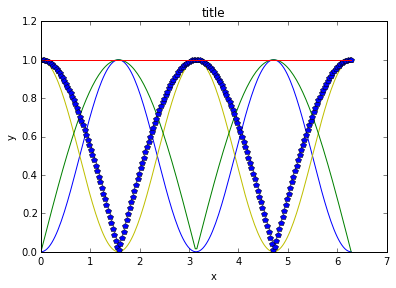

In [24]:
%matplotlib inline
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('title')
#axes.plot(x, np.sin(x), 'r')
#axes.plot(x, np.cos(x), 'g')
axes.plot(x, np.sin(x)**2, 'b')
axes.plot(x, np.cos(x)**2, 'y')
axes.plot(x, np.abs(np.sin(x)), 'g')
axes.plot(x, np.abs(np.cos(x)), 'p')
axes.plot(x, np.sin(x)**2 + np.cos(x)**2, 'r')

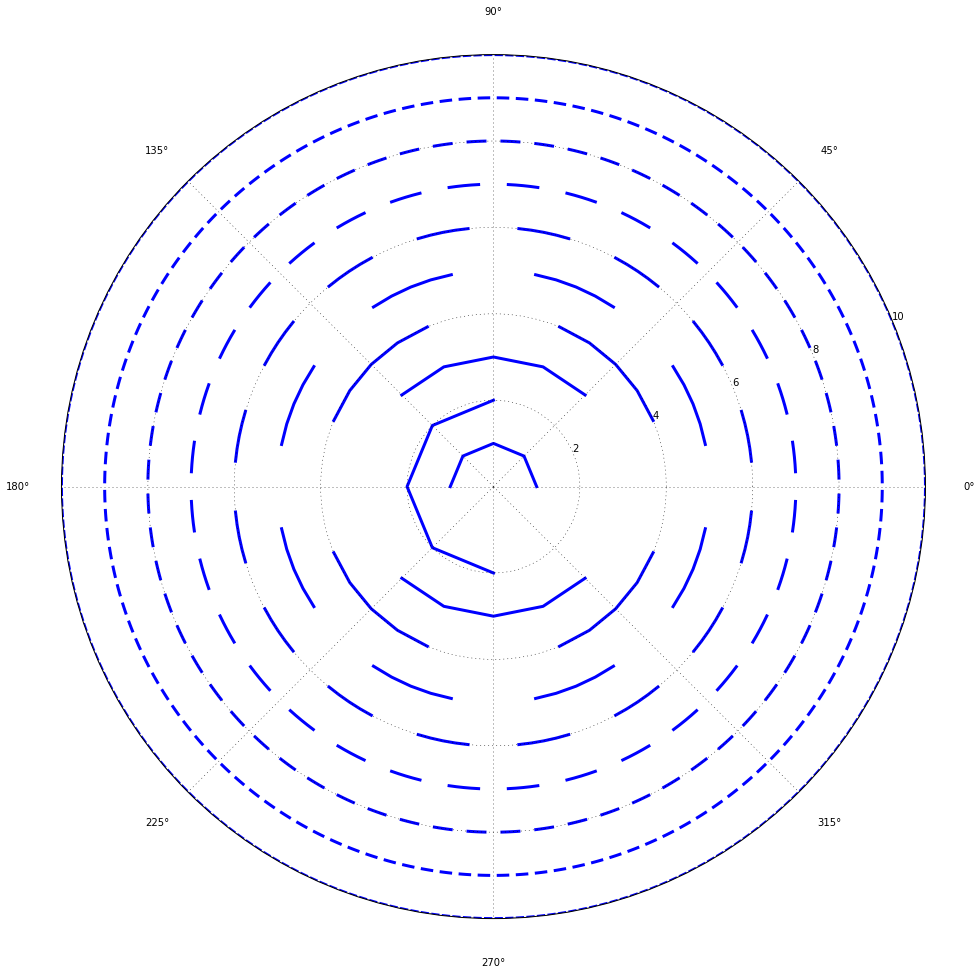

In [101]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_axes([0.0, 0.0, .6, .6], polar=True)
for i in range(0, 9):
    n = 2**i
    size = np.pi / (i / 2 + 1) ** 2
    size = np.pi / n
    shift = size / 2
    t1 = np.linspace(i + 2, i+2, 5)
    for j in range (0, n):
        t = np.linspace(0 + shift+size*2*j, size*(2*j+1) + shift, 5)
        ax.plot(t, t1, color='blue', lw=3);
t1 = np.linspace(1, 1, 5)
t = np.linspace(0, np.pi, 5)
ax.plot(t, t1, color='blue', lw=3);
# fig.savefig('graph.png')